In [1]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\enhan\appdata\local\temp\pip-req-build-9ojoqrzr
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 6a9c8dadac04eb85befc935043e3e2cce914267f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\enhan\AppData\Local\Temp\pip-req-build-9ojoqrzr'

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from chronos import ChronosPipeline
import time
import re
import os, random, numpy as np
from transformers import set_seed

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
SEED = 50
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)  # HF helper that seeds Python, NumPy, PyTorch


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
)

In [4]:
# Load the data
filename = "2023-06-01_2023-08-31_load_per_hour.csv"
input_filename = f"../data/{filename}"
data = pd.read_csv(input_filename)

# Split the data into 80% training and 20% testing
train_size = int(len(data) * 0.8)
train_data = data["load"][:train_size]
test_data = data["load"][train_size:]

# Convert training and testing data to tensors
train_context = torch.tensor(train_data.values, dtype=torch.float32)
test_context = torch.tensor(test_data.values, dtype=torch.float32)

In [5]:
# Predict on the testing data
start_time = time.time()
forecast = pipeline.predict(
    context=torch.tensor(train_context, dtype=torch.float32),
    prediction_length=len(test_context),
    num_samples=100,
    temperature=1.0,
    top_k=50,
)
end_time = time.time()
training_time = end_time- start_time
print(training_time)

C:\Users\enhan\AppData\Local\Temp\ipykernel_39964\3208556095.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context=torch.tensor(train_context, dtype=torch.float32),
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


127.65831685066223


In [6]:
# Convert predictions to DataFrames
# Compute the median forecast across samples
median_forecast = np.median(forecast[0], axis=0)

test_dates = pd.to_datetime(data['date'].iloc[train_size:]).reset_index(drop=True)

# Align lengths defensively
n = min(len(test_dates), len(test_data), len(median_forecast))
median_forecast_df = pd.DataFrame({
    "date": test_dates.iloc[:n],
    "Actual": np.asarray(test_data)[:n],
    "Median Predicted Load": np.asarray(median_forecast)[:n]
})

# Persist with dates in filename for this date_range
date_range = re.search(r"\d{4}-\d{2}-\d{2}_\d{4}-\d{2}-\d{2}", input_filename).group()
out_csv = f"../forecasting_results/chronos_results/testing_predictions_with_actual_{date_range}.csv"
median_forecast_df.to_csv(out_csv, index=False)
print(f"Saved testing predictions with dates to: {out_csv}")


Saved testing predictions with dates to: ../forecasting_results/chronos_results/testing_predictions_with_actual_2023-06-01_2023-08-31.csv


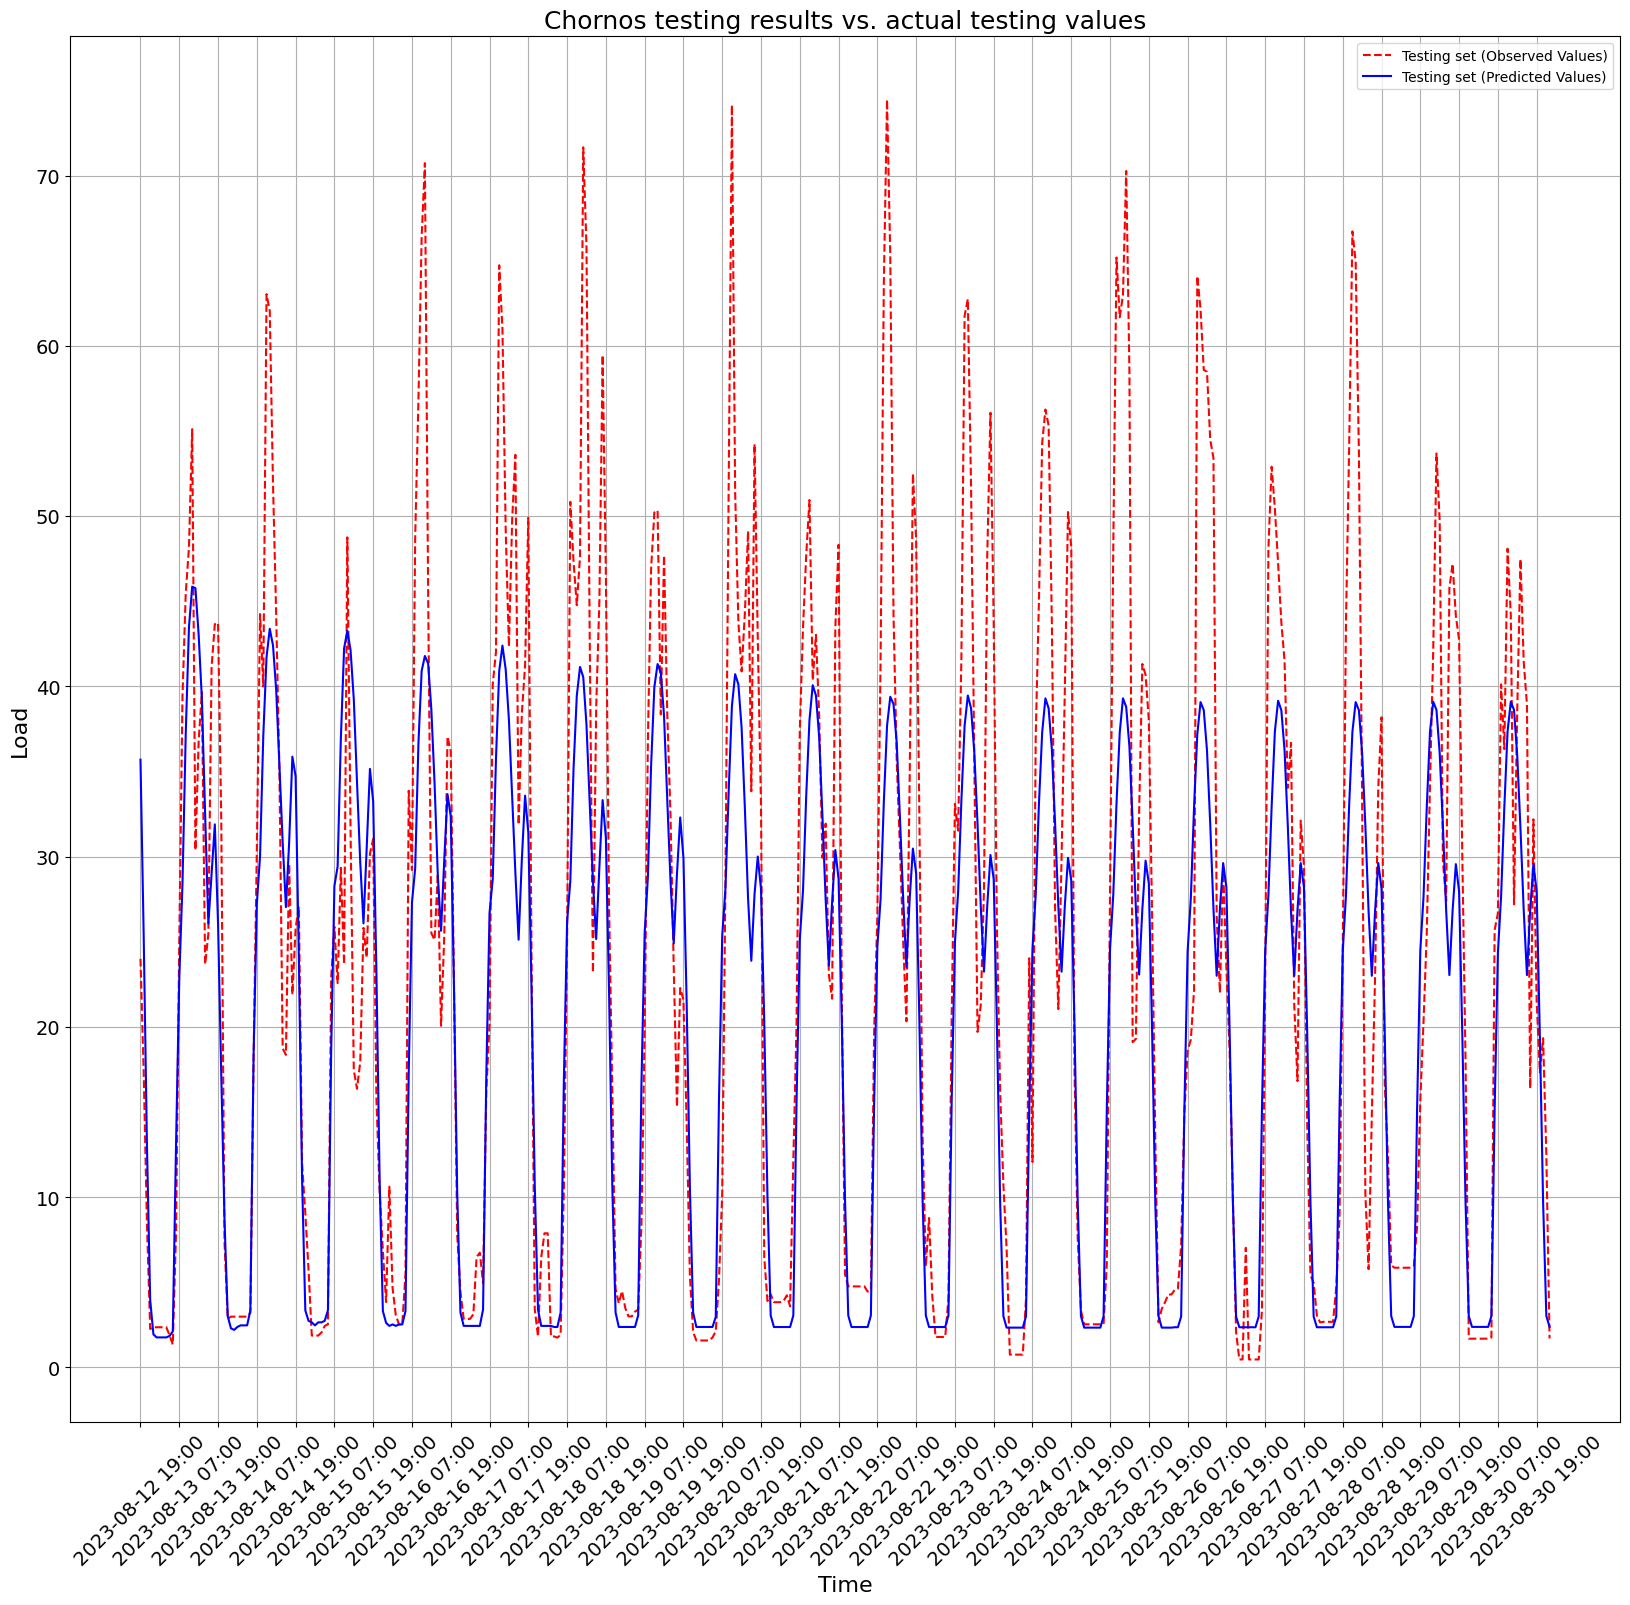

In [7]:
# Ensure "date" is in datetime format
data["date"] = pd.to_datetime(data["date"])
# Plot the results
plt.figure(figsize=(20, 18))

# Plot testing data
plt.plot(data["date"][train_size:], test_data, label="Testing set (Observed Values)", color="red", linestyle="--")
plt.plot(data["date"][train_size:], median_forecast_df["Median Predicted Load"], label="Testing set (Predicted Values)", color="blue")

# Select every 6th timestamp for x-ticks
six_hour_ticks = data["date"][train_size::12]

# Set x-ticks to every 6 hours
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("X Axis Label", fontsize=16)
plt.ylabel("Y Axis Label", fontsize=16)
plt.title("Chornos testing results vs. actual testing values", fontsize=18)

plt.xticks(ticks=six_hour_ticks, labels=six_hour_ticks.dt.strftime("%Y-%m-%d %H:%M"), rotation=45)

plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.savefig(f"../forecasting_results/chronos_results/time_series_comparison_actual_vs_predicted_testing_set_{date_range}.png")
plt.show()


Saved metrics to ../forecasting_results/chronos_results/evaluation_metrics_2023-06-01_2023-08-31.csv
Mean Squared Error (MSE): 112.4159307481973
Mean absolute percentage Error (MAPE): 0.43316994454501967
Mean absolute error (MAE): 7.350990152957778
R² Score: 0.7120920432689932


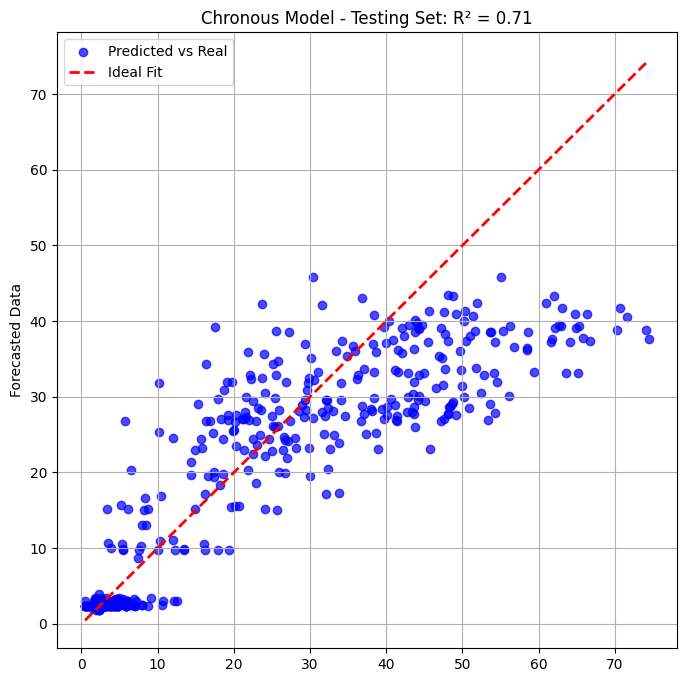

In [8]:
# Compute MSE and R² Score
test_mse = mean_squared_error(test_data, median_forecast)
test_MAPE = mean_absolute_percentage_error(test_data, median_forecast)
test_mae = mean_absolute_error(test_data, median_forecast)
test_r2 = r2_score(test_data, median_forecast)

# Build metrics table (round if you like)
metrics_df = pd.DataFrame({
    "Metric": ["MSE", "MAPE", "MAE", "R2","Training_time_sec"],
    "Value":  [test_mse, test_MAPE, test_mae, test_r2, training_time]
})

# Save
output_filename = f"../forecasting_results/chronos_results/evaluation_metrics_{date_range}.csv"  # change path/name as needed
metrics_df.to_csv(output_filename, index=False)

print(f"Saved metrics to {output_filename}")
# Print the metrics
print(f"Mean Squared Error (MSE): {test_mse}")
print(f"Mean absolute percentage Error (MAPE): {test_MAPE}")
print(f"Mean absolute error (MAE): {test_mae}")
print(f"R² Score: {test_r2}")

# Scatter plot of real vs. forecasted testing data
plt.figure(figsize=(8, 8))
plt.scatter(test_data, median_forecast, alpha=0.7, color="blue", label="Predicted vs Real")
plt.plot([test_data.min(), test_data.max()], [test_data.min(), test_data.max()], color="red", lw=2, linestyle="--", label="Ideal Fit")
plt.title(f'Chronous Model - Testing Set: R² = {test_r2:.2f}')
plt.ylabel("Forecasted Data")
plt.legend()
plt.grid(True)
plt.savefig(f"../forecasting_results/chronos_results/comparison_actual_vs_predicted_testing_set_{date_range}.pdf")
plt.show()